## Import Necessary Packages

In [1]:
import glob
import numpy as np
import xarray as xr
from scipy.ndimage import uniform_filter1d
import proplot as pplt
%config InlineBackend.figure_format = 'retina'
pplt.rc.update({'font.size':12})
import warnings
warnings.filterwarnings('ignore')

## Import  $w_{500}$ and $h_f$ Data

Here, we load in frozen moist static energy, ```hf```, and the vertical velocity at 500 hPa, ```w500```. Sicne we are using 3D data, we define $w_{500}$ as the values of $w$ at the pressure level closest to 500 hPa for each case.

In [16]:
path  = '/ocean/projects/atm200007p/ajenney/rcemip-large/'
cases = ['nz_32','nz_64','nz_128']
w500  = []
hf    = []
for i,case in enumerate(cases):
    print('Working on '+case)
    pbackground = xr.open_dataset(glob.glob(path+case+'/OUT_3D/p/*.nc')[0]).p
    i500 = np.argmin(np.abs(pbackground.values-500))
    w500.append((xr.open_mfdataset(np.sort(glob.glob(path+case+'/OUT_3D/W/*.nc')))).isel(z=i500).W)    
    hf.append(xr.open_mfdataset(np.sort(glob.glob(path+case+'/OUT_3D/FMSE/'+'*.nc'))))

Working on nz_32
Working on nz_64
Working on nz_128


## Calculate Aggregation Metrics

We calculate subsidence fraction, ```subfrac```, as the fractional area of the domain where subsidence occurs at 500 hPa ($w_{500}$ < 0). Note that both the subsidence fraction and the spatial variance of column-integrated frozen moist static energy ($\langle h_f \rangle'^2$), or ```hfvar```, are calculated using daily-averaged values.

In [23]:
w500daily = []
subfrac   = []
hfdaily   = []
hfvar     = []
for i,case in enumerate(cases):
    print('Working on '+case)
    w500daily.append(w500[i].groupby(np.floor(w500[i].time)).mean('time'))
    subfrac.append(np.nanmean(w500daily[i]<0,axis=(1,2)))
    hfdaily.append(hf[i].groupby(np.floor(hf[i].time)).mean('time'))
    hfvar.append(hfdaily[i].fmse_vint.var(dim=('x','y'))/1e15)

Working on nz_32
Working on nz_64
Working on nz_128


## Plot Fig. 5: Time Series of Aggregation Metrics

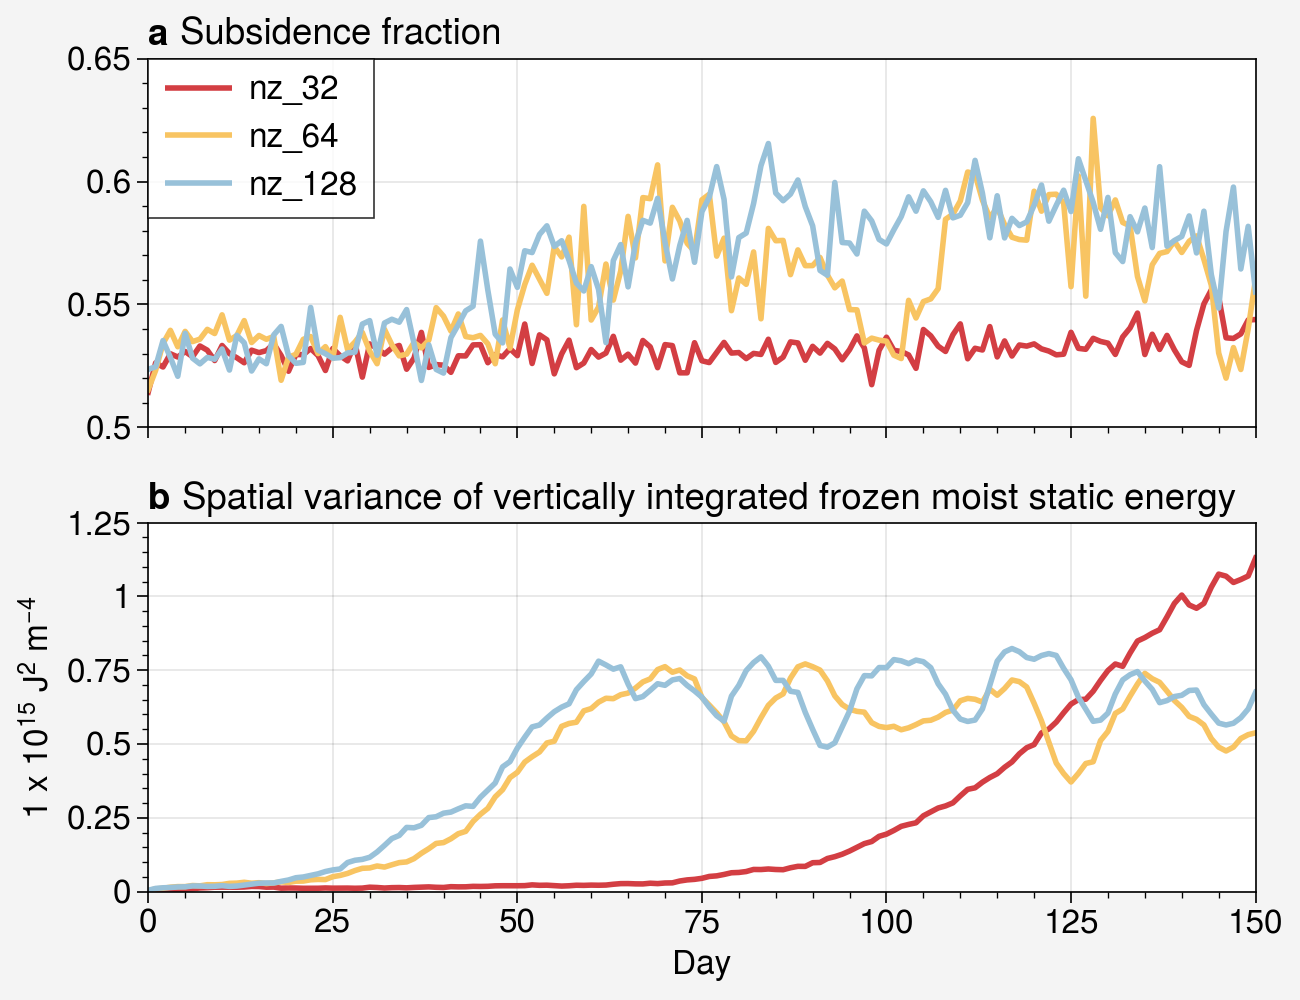

In [34]:
fig,axs = pplt.subplots(nrows=2,ncols=1,width=6.5,height=5,sharex=True,sharey=False)
axs.format(xlabel='Day',xlim=(0,150),xticks=25,ylabel='',abc='a',abcloc='l',titleloc='l')
cmap=np.asarray([[211,62,67,255],[248,196,98,255],[152,193,217,255]])/255; linewidth=2
for i,case in enumerate(cases):
    axs[0].plot(subfrac[i],color=cmap[i],label=case,linewidth=linewidth)
    axs[0].format(title='Subsidence fraction',ylim=(0.5,0.65))
    axs[0].legend(loc='ul',ncols=1)
    axs[1].plot(hfvar[i],color=cmap[i],linewidth=linewidth)
    axs[1].format(title='Spatial variance of vertically integrated frozen moist static energy',
                  ylabel='1 x 10$^{15}$ J$^{2}$ m$^{-4}$',ylim=(0,1.25))